# Finalized Data Preprocessing and Model Creation

In [2]:
!pip3 install -r requirements.txt

## Data Preprocessing

In [3]:
# for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import yfinance as yf
from sklearn import linear_model
# Split later
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD

/var/folders/94/smsw3ygd62x427m2vt3rdq100000gn/T/ipykernel_86181/1116658333.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


/Users/cedric/Documents/ucsd-repos/cse151a-project/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


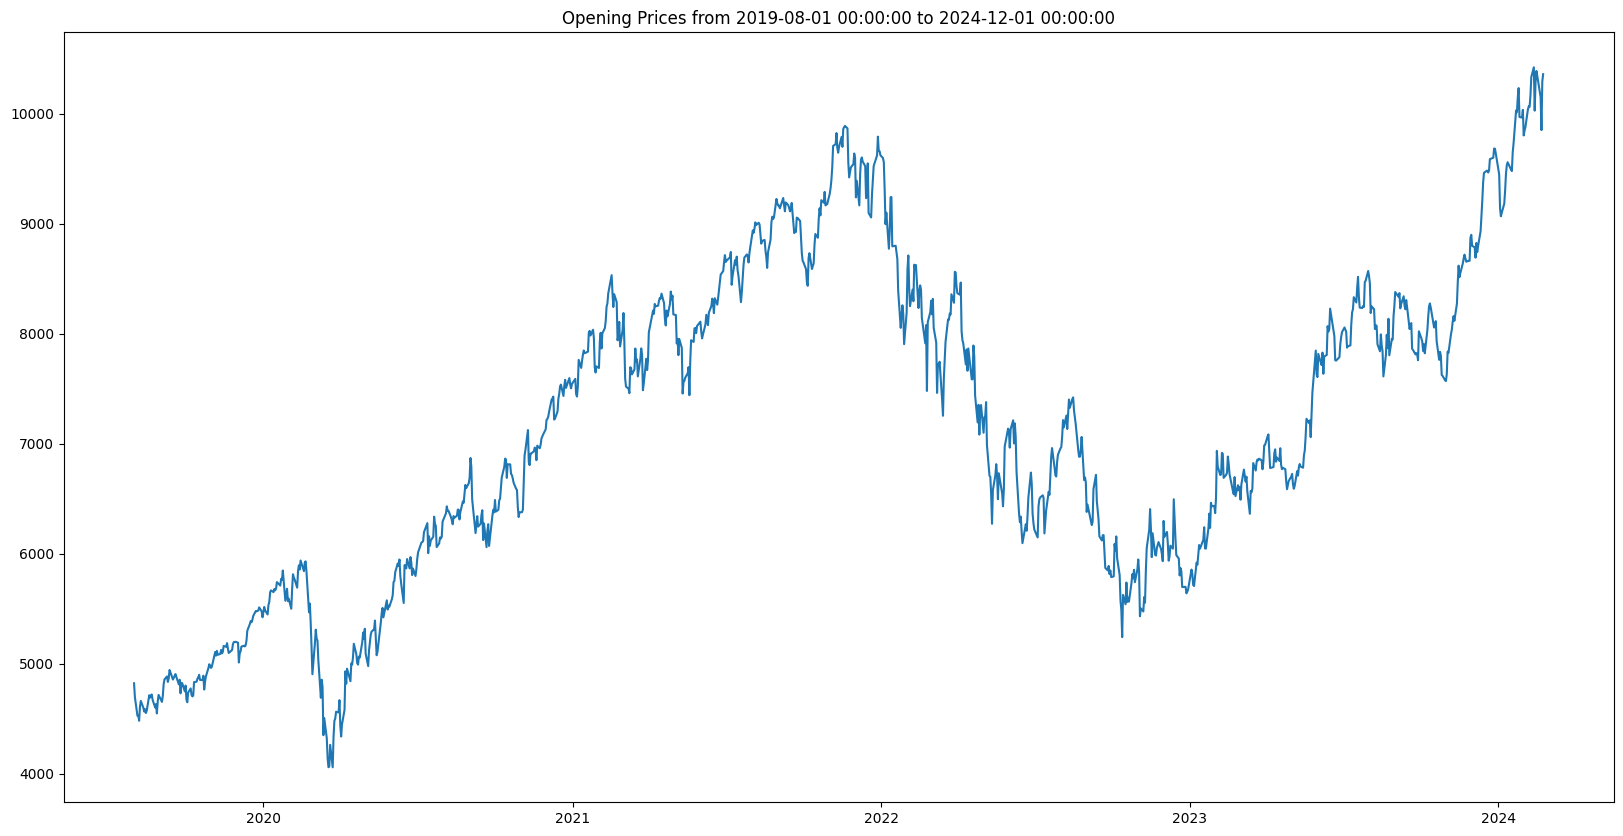

In [4]:
# initialize parameters 
start_date = datetime(2019, 8, 1)
end_date = datetime(2024, 12, 1)

# get the data 
stock_data = yf.download('^NDXT', start = start_date,
                         end = end_date)

stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8') # False: not include index

# display 
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(stock_data['Open'])
plt.show()

In [5]:
def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date

"""
@param stock_data: original stock_data df
@param week_end: layoff date
@param period: number of days to look back, defaults to 7

@return % of change in NDXT index price during last week before layoff date 
"""
def weekly_price_diff(stock_data, week_end, period: int = 7):
    # week end date in format datetime(YYYY,MM,DD)

    if (week_end < datetime(2020, 1, 15)):
        return 0
    date_col_stock_data = stock_data.reset_index() # add DATE as column
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days = period))

    price_end = stock_data['Open'][date_end_closest]
    price_start = stock_data['Open'][date_start_closest]
    price_diff = (price_end - price_start) / price_start * 100

    return price_diff # in PERCENTAGE

# ! USAGE EXAMPLE
price_diff = weekly_price_diff(stock_data, datetime(2022, 4, 11))
price_diff = round(price_diff, 2)
print(f"Diff between 11 APR 2022 and week before: {price_diff}%")

Diff between 11 APR 2022 and week before: -7.59%


In [6]:
# TODO: ADD RETRIEVED STOCK CHANGE TO DATA_PD

week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8')
stock_data

,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2019-08-01,4821.149902,4924.919922,4726.339844,4762.810059,4762.810059,425800,0
2019-08-02,4695.549805,4712.990234,4629.250000,4655.560059,4655.560059,356000,0
2019-08-05,4525.939941,4534.649902,4434.459961,4469.970215,4469.970215,427900,0
2019-08-06,4530.689941,4562.890137,4481.229980,4531.810059,4531.810059,317500,0
2019-08-07,4480.180176,4563.459961,4470.759766,4550.560059,4550.560059,321600,0
...,...,...,...,...,...,...,...
2024-02-16,10345.860352,10373.459961,10201.889648,10225.030273,10225.030273,0,0.12514
2024-02-20,10150.830078,10191.370117,9987.280273,10122.299805,10122.299805,0,1.231328
2024-02-21,9850.410156,9940.769531,9826.790039,9939.389648,9939.389648,0,-4.215232


In [7]:
def str_to_datetime(dt_string):
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")

layoff_data = pd.read_csv("tech_layoffs.csv")

layoff_data["Date_layoffs"] = layoff_data["Date_layoffs"].apply(lambda x: str_to_datetime(x))
layoff_data['Company'] = layoff_data['Company'].replace({'SaleSan Franciscoorce': 'Salesforce'})
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data = layoff_data[layoff_data['Continent'] == 'North America']
layoff_data = layoff_data[layoff_data['Country'] == 'USA']
layoff_data = layoff_data[layoff_data['Company_Size_before_Layoffs'] >= 10]
layoff_data = layoff_data.drop(columns=["Company", "lat", "lng", "Continent", "Country", "#"])

cities_by_timezone = {
    'Pacific Time': ['Los Angeles', 'San Francisco Bay Area', 'Seattle', 'Portland', 'San Luis Obispo', 'Sacramento', 'San Diego', 'Santa Barbara', 'Camarillo', 'Fremont', 'Bend', 'Reno', 'Spokane', 'Las Vegas', 'Fresno'],
    'Mountain Time': ['Denver', 'Boulder', 'Salt Lake City', 'Missoula', 'Santa Fe', 'Phoenix', 'Lehi', 'Logan', 'Boise'],
    'Central Time': ['Austin', 'Chicago', 'Minneapolis', 'Milwaukee', 'Nashville', 'Dallas', 'Cincinnati', 'Columbus', 'Indianapolis', 'Nebraska City', 'Kansas City'],
    'Eastern Time': ['New York City', 'Boston', 'Atlanta', 'Ann Arbor', 'Miami', 'Detroit', 'Stamford', 'Washington DC', 'Philadelphia', 'Raleigh', 'Walnut', 'Madison', 'Dover', 'Burlington', 'Wilmington', 'Nashua', 'Baltimore', 'Tampa Bay']
}

def get_timezone(city):
    for timezone, cities in cities_by_timezone.items():
        if city in cities:
            return timezone
    return None

# Assign new attribute 'Timezone' based on city
layoff_data['Region'] = layoff_data['Location_HQ'].map(get_timezone)
layoff_data = layoff_data.drop(columns=["Location_HQ", "Company_Size_after_layoffs", "Laid_Off"]) 

#Incorporate stock price
layoff_data = layoff_data.reset_index()

#Create a new column for stock price change, and add it to the layoff_data_with_date_col dataframe
layoff_data.insert(1, "stock_delta", layoff_data["Date_layoffs"].apply(lambda x: weekly_price_diff(stock_data, x, period=90)))
layoff_data  # bug: several stock_delta values are 0, which is highly improbable.


industry_encoder = LabelEncoder()
layoff_data['industry_encoded'] = industry_encoder.fit_transform(layoff_data['Industry'])

time_encoder = LabelEncoder()
layoff_data['Region_encoded'] = industry_encoder.fit_transform(layoff_data['Region'])

# Create LabelEncoder instance for stage column
stage_encoder = LabelEncoder()
layoff_data['stage_encoded'] = stage_encoder.fit_transform(layoff_data['Stage'])
layoff_data = layoff_data.drop(columns=["Industry", "Stage","Year","Region"])
layoff_data['Money_Raised_in_$_mil'] = layoff_data['Money_Raised_in_$_mil'].str.replace('$', '').astype(float) * 1000000

#convert date layoffs to unix
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(lambda x: int(datetime.timestamp(x)))


Y = layoff_data['Percentage']

# layoff_data = layoff_data.drop(columns=["Date_layoffs"])

industry = layoff_data['industry_encoded']
stage = layoff_data['stage_encoded'] 
region = layoff_data['Region_encoded']

# Reshape to a 2D array
industry = industry.values.reshape(-1, 1)
stage = stage.values.reshape(-1, 1)
region = region.values.reshape(-1, 1)

# #display
# display(layoff_data)


# One-hot encode
encoder = OneHotEncoder(sparse_output=False, drop='first')
industry_onehot = encoder.fit_transform(industry)
encoder = OneHotEncoder(sparse_output=False, drop='first')
stage_onehot = encoder.fit_transform(stage)
encoder = OneHotEncoder(sparse_output=False, drop='first')
region_onehot = encoder.fit_transform(region)

# Display the one-hot encoded arrays

# Drop the original categorical columns from layoff_data
layoff_data = layoff_data.drop(columns=["industry_encoded", "stage_encoded", "Region_encoded"])
layoff_data = layoff_data.drop(columns=["Percentage"])
display(layoff_data)

# Concatenate numerical features and one-hot encoded features
data_array = np.hstack((layoff_data.values, industry_onehot, stage_onehot, region_onehot))

X = data_array

print(X.shape)
print(Y.shape)

,Date_layoffs,stock_delta,Company_Size_before_Layoffs,Money_Raised_in_$_mil
0,1583996400,-17.938421,50,90000000.0
1,1584082800,-15.003683,80,45000000.0
2,1584342000,-19.758224,591,79000000.0
3,1584342000,-19.758224,16,6000000.0
4,1584514800,-24.824380,20,4000000.0
...,...,...,...,...
897,1704873600,14.204551,188000,26000000.0
898,1704873600,14.204551,450,57000000.0
899,1704960000,15.684460,1000,995000000.0
900,1704960000,15.684460,2000,14000000.0


(902, 51)
(902,)


In [8]:
print(X.shape)
print(Y.shape)

(902, 51)
(902,)


In [9]:
# Assuming you have already defined X and Y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shapes: X_train =", X_train.shape, ", Y_train =", y_train.shape)
print("Testing set shapes: X_test =", X_test.shape, ", Y_test =", y_test.shape)

Training set shapes: X_train = (721, 51) , Y_train = (721,)
Testing set shapes: X_test = (181, 51) , Y_test = (181,)


In [10]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS: " + str(layoff_data.values[0]))
print("INDUSTRY ONEHOT: " + str(industry_onehot[0]))
print("STAGE ONEHOT: " + str(stage_onehot[0]))
print("REGION ONEHOT: " + str(region_onehot[0]))

print("X: " + str(X[0]))


LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [11]:
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

## Polynomial Regression Model

In our first model, we wanted to determine if a polynomial regression model
would work in predicting the percentage of employees that would be laid off.

In [12]:
mse_arr = []

In [13]:
logreg = LinearRegression()

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_df = pd.DataFrame(X_train_np)
y_train_df = pd.DataFrame(y_train_np)

logreg.fit(X_train_df, y_train_df)

yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

MSE_train = np.mean((y_train.values - yhat_train)**2)
MSE_test = np.mean((y_test.values - yhat_test)**2)

mse_arr.append((MSE_train, MSE_test))

print(f"MSE_train: {MSE_train}")
print(f"MSE_test: {MSE_test}")


MSE_train: 484.89271439936135
MSE_test: 409.1260230736743


In [14]:
for k in range(2,5):
    # Create kth degree polynomial
    poly = PolynomialFeatures(k)

    # Convert features to fit polynomial model
    train_features = poly.fit_transform(X_train_df)
    test_features = poly.fit_transform(X_test)

    # Create polynomial regression
    polyreg = LinearRegression()
    polyreg.fit(train_features, y_train_df)

    # Get predictions
    yhat_train = polyreg.predict(train_features)
    yhat_test = polyreg.predict(test_features)

    # Print resulting MSE
    MSE_train = np.mean((y_train.values - yhat_train) ** 2)
    MSE_test = np.mean((y_test.values - yhat_test) ** 2)

    mse_arr.append((MSE_train, MSE_test))

    print(f'Degree: {k}')
    print(f'    MSE_train: {MSE_train}')
    print(f'    MSE_test:  {MSE_test}')

Degree: 2
    MSE_train: 518.81818206198
    MSE_test:  496.9937884425991
Degree: 3
    MSE_train: 531.4943415961401
    MSE_test:  631.3369568130447
Degree: 4
    MSE_train: 455.39290839201755
    MSE_test:  880.0874788192211


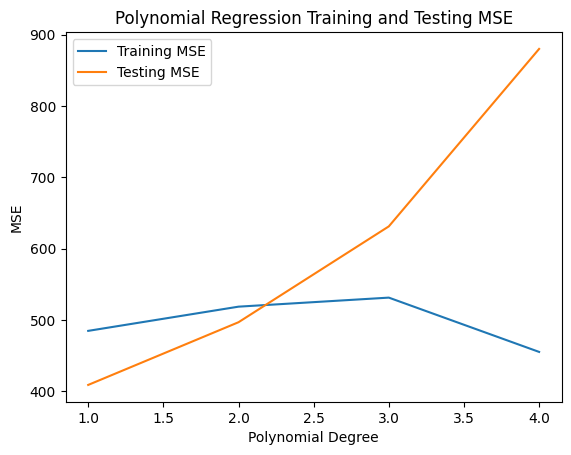

In [15]:
mse_train = [pair[0] for pair in mse_arr]
mse_test = [pair[1] for pair in mse_arr]

degrees = range(1, len(mse_arr) + 1)

plt.plot(degrees, mse_train, label='Training MSE')
plt.plot(degrees, mse_test, label='Testing MSE')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression Training and Testing MSE')
plt.legend()

plt.show()

### Model 1 Analysis

From our fitting graph, we can conclude from our high MSE that our model is
underfitting regardless of the degree of our polynomial.

For our next two models, we are considering Automatic Relevance Determination
regression and a Neural Network. With ARD regression, we want to see if a
different regularization technique will better assign weights depending on the
feature in our modeling process. Meanwhile, a Neural Network may be better
suited in finding patterns within our data.

### Model 1 Conclusion

From our first model, we can conclude that polynomial regression might not be
the best model to use given our data. The high training and testing MSE along
with the long training times. It is possible that higher polynomial degrees or
isolating some of our input features may improve the performance of our model.
However, we would still run into issues where the polynomial regression takes
a long time to fit with our training data. Thus, we are less likely to use
this in our data.

## ARD Regression

In [77]:
mpg_weight = ARDRegression().fit(X_train, y_train)
Y_pred = mpg_weight.predict(X_test)
print('Testing Mean Squared Error:', mean_squared_error(Y_pred, y_test))

Testing Mean Squared Error: 290.17133207240596


## Neural Net

In [78]:
# Building model, splitting data, fitting model, and predicting points
def build_nn():
  model = Sequential([
      Dense(12, activation='sigmoid', input_dim=51),
      Dense(12, activation='sigmoid'),
      Dense(12, activation='sigmoid'),
      Dense(12, activation='sigmoid'),
      Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=SGD(learning_rate=0.3), loss='mse', metrics=['mse'])
  return model

classifier = KerasRegressor(model=build_nn, epochs=100, batch_size=20, verbose=0)
hist = classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print('Testing Mean Squared Error:', mean_squared_error(predictions, y_test))

Testing Mean Squared Error: 584.9784227081562


In [21]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS: " + str(layoff_data.values[0]))
print("INDUSTRY ONEHOT: " + str(industry_onehot[0]))
print("STAGE ONEHOT: " + str(stage_onehot[0]))
print("REGION ONEHOT: " + str(region_onehot[0]))

print("X: " + str(X[0]))


LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [22]:
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

Linear Regression Model

In [23]:
logreg = linear_model.LinearRegression()

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_df = pd.DataFrame(X_train_np)
y_train_df = pd.DataFrame(y_train_np)

logreg.fit(X_train_df, y_train_df)

yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

MSE_train = np.mean((y_train.values - yhat_train)**2)
MSE_test = np.mean((y_test.values - yhat_test)**2)
print(f"MSE_train: {MSE_train}")
print(f"MSE_test: {MSE_test}")


MSE_train: 484.89271442931323
MSE_test: 409.1260231141291


ARD Regression

In [24]:
mpg_weight = ARDRegression().fit(X_train, y_train)
Y_pred_test = mpg_weight.predict(X_test)
Y_pred_train = mpg_weight.predict(X_train)

print('Testing Mean Squared Error:', mean_squared_error(Y_pred_test, y_test))
print('Training Mean Squared Error:', mean_squared_error(Y_pred_train, y_train))

Testing Mean Squared Error: 290.17133207240596
Training Mean Squared Error: 386.4592934222615


Neural Net

In [25]:
# Building model, splitting data, fitting model, and predicting points
def build_nn():
  model = Sequential([
      Dense(12, activation='sigmoid', input_dim=51),
      Dense(12, activation='sigmoid'),
      Dense(12, activation='sigmoid'),
      Dense(12, activation='sigmoid'),
      Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=SGD(learning_rate=0.3), loss='mse', metrics=['mse'])
  return model

classifier = KerasRegressor(model=build_nn, epochs=100, batch_size=20, verbose=0)
hist = classifier.fit(X_train, y_train)
predictions_test = classifier.predict(X_test)
predictions_train = classifier.predict(X_train)
print('Testing Mean Squared Error:', mean_squared_error(predictions_test, y_test))
print('Training Mean Squared Error:', mean_squared_error(predictions_train, y_train))




Testing Mean Squared Error: 584.9785179527101
Training Mean Squared Error: 786.0688607895703
